In [583]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

from astropy.table import Table,join,hstack,vstack
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import corner
from matplotlib.colors import LogNorm
import scipy.optimize

In [584]:
# First read in the unvalidated GALAH DR4 file

setup = 'allstar'

galah_dr4_raw = Table.read('../catalogs/galah_dr4_'+setup+'_230206.fits')
# galah_dr4_raw = Table.read('../spectrum_post_processing/galah_dr4_allstar_plxcom_not_validated.fits')
galah_dr4_raw['source_id'] = galah_dr4_raw['gaiadr3_source_id']
if setup == 'allspec':
    if np.isnan(galah_dr4_raw['e_logg'][0]):
        galah_dr4_raw['e_logg'] = 0.05

# 1) Accuracy

# Gaia RV

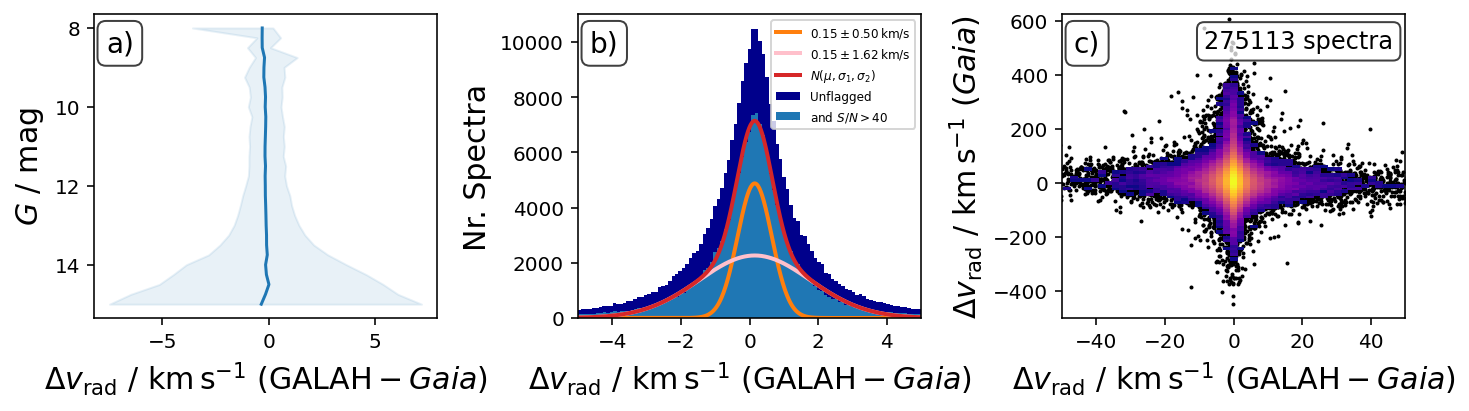

In [617]:
f, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(10,3))

apply_flags = (
    (galah_dr4_raw['flag_sp'] == 0) &
#     (galah_dr4_raw['phot_g_mean_mag'] < 12) &
    np.isfinite(galah_dr4_raw['rv_gaia_dr3']) & 
    np.isfinite(galah_dr4_raw['rv_comp_1'])
    )

vrad_bins = np.arange(8,15.25,0.25)
vrad_step = 0.5*(vrad_bins[1]-vrad_bins[0])

vrad_gaia = []

for vrad_bin in vrad_bins:
    in_vrad_bin = (galah_dr4_raw['phot_g_mean_mag'] > vrad_bin-vrad_step) & (galah_dr4_raw['phot_g_mean_mag'] <= vrad_bin+vrad_step)
    if len(galah_dr4_raw['phot_g_mean_mag'][in_vrad_bin]) > 10:
        vrad_gaia.append(np.nanpercentile(galah_dr4_raw['rv_gaia_dr3'][in_vrad_bin] - galah_dr4_raw['rv_comp_1'][in_vrad_bin],q=[16,50,84]))
    else:
        vrad_gaia.append([np.nan,np.nan,np.nan])
        
vrad_gaia = np.array(vrad_gaia)
        
vrad_gaia_overall = np.nanpercentile(galah_dr4_raw['rv_gaia_dr3'] - galah_dr4_raw['rv_comp_1'],q=[16,50,84])

ax.plot(
    vrad_gaia[:,1],
    vrad_bins,
    c = 'C0',
    label = r'$\mathrm{GALAH~DR4} - Gaia~\mathrm{DR3}$'
)
ax.fill_betweenx(
    vrad_bins,
    vrad_gaia[:,0],
    vrad_gaia[:,2],
    alpha = 0.1,
    color = 'C0'
)
ax.set_ylabel(r'$G~/~\mathrm{mag}$',fontsize=15)
ax.set_xlabel(r'$\Delta v_\mathrm{rad}~/~\mathrm{km\,s^{-1}}~(\mathrm{GALAH} - Gaia)$',fontsize=15)
ax.set_ylim(ax.get_ylim()[::-1])

ax1.hist(
    galah_dr4_raw['rv_comp_1'][apply_flags] - galah_dr4_raw['rv_gaia_dr3'][apply_flags],
    bins = np.linspace(-5,5,100),
    color='darkblue',
    label=r'Unflagged'
)

ax2.scatter(
    galah_dr4_raw['rv_comp_1'][apply_flags] - galah_dr4_raw['rv_gaia_dr3'][apply_flags],
    galah_dr4_raw['rv_gaia_dr3'][apply_flags],
    c='k',
    zorder=1,
    s=1,
)
ax2.hist2d(
    galah_dr4_raw['rv_comp_1'][apply_flags] - galah_dr4_raw['rv_gaia_dr3'][apply_flags],
    galah_dr4_raw['rv_gaia_dr3'][apply_flags],
    bins = (np.linspace(-100,100,100),np.linspace(-500,500,100)),
    zorder=2,
    cmap='plasma',
    cmin=5,
    norm=LogNorm(),
    label=r'Unflagged'
);

stricter_flags = apply_flags & (galah_dr4_raw['snr_px_ccd2'] > 40)
first_median = np.median(galah_dr4_raw['rv_comp_1'][stricter_flags] - galah_dr4_raw['rv_gaia_dr3'][stricter_flags])
first_mean = np.mean(galah_dr4_raw['rv_comp_1'][stricter_flags] - galah_dr4_raw['rv_gaia_dr3'][stricter_flags])
first_std = np.std(galah_dr4_raw['rv_comp_1'][stricter_flags] - galah_dr4_raw['rv_gaia_dr3'][stricter_flags])

def gauss_2(x,a1,x1,sigma1,a2,sigma2):
    return np.abs(a1)*np.exp(-(x-x1)**2/(2.*np.abs(sigma1)**2)) +  np.abs(a2)*np.exp(-(x-x1)**2/(2.*np.abs(sigma2)**2))

def gauss(x,a,x0,sigma):
    return np.abs(a)*np.exp(-(x-x0)**2/(2*sigma**2))


hist_bin, x, = np.histogram(galah_dr4_raw['rv_comp_1'][stricter_flags] - galah_dr4_raw['rv_gaia_dr3'][stricter_flags], bins=np.linspace(-10,10,200))
bin_means = x[:-1]+0.5*(x[1]-x[0])

opt_parms, parm_cov = scipy.optimize.curve_fit(gauss_2,bin_means,hist_bin,p0=[10000, 0.21, 0.52, 3750, 1.50])

ax1.hist(galah_dr4_raw['rv_comp_1'][stricter_flags] - galah_dr4_raw['rv_gaia_dr3'][stricter_flags],bins=np.linspace(-10,10,200),label=r'and $S/N > 40$',color='C0',lw=2)
ax1.plot(np.linspace(-10,10,1000),gauss(np.linspace(-10,10,1000),*opt_parms[:3]),label=r'$'+"{:.2f}".format(opt_parms[1])+'\pm'+"{:.2f}".format(opt_parms[2])+'\,\mathrm{km/s}$',color='C1',lw=2)
ax1.plot(np.linspace(-10,10,1000),gauss(np.linspace(-10,10,1000),*opt_parms[[3,1,4]]),label=r'$'+"{:.2f}".format(opt_parms[1])+'\pm'+"{:.2f}".format(opt_parms[4])+'\,\mathrm{km/s}$',color='pink',lw=2)
ax1.plot(np.linspace(-10,10,1000),gauss_2(np.linspace(-10,10,1000),*opt_parms),label=r'$N(\mu,\sigma_1,\sigma_2)$',c='C3',lw=2)

props = dict(boxstyle='round', facecolor='w', alpha=0.75)
ax.text(0.035, 0.95, 'a)', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax1.text(0.035, 0.95, 'b)', transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax2.text(0.035, 0.95, 'c)', transform=ax2.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax2.text(1-0.035, 0.95, str(len(galah_dr4_raw['rv_comp_1'][apply_flags]))+' spectra', transform=ax2.transAxes, fontsize=12,
        verticalalignment='top', ha='right', bbox=props)

gaia_rv_gauss2_fit = r'$'+"{:.2f}".format(opt_parms[1])+'\pm'+"{:.2f}".format(opt_parms[2])+'\pm'+"{:.2f}".format(opt_parms[4])+'$'

ax1.set_xlim(-5,5)
ax2.set_ylim(-500,625)
ax2.set_xlim(-50,50)
ax1.legend(fontsize=6,loc='upper right')
ax1.set_xlabel(r'$\Delta v_\mathrm{rad}~/~\mathrm{km\,s^{-1}}~(\mathrm{GALAH} - Gaia)$',fontsize=15)
ax1.set_ylabel(r'Nr. Spectra',fontsize=15)
ax2.set_ylabel(r'$\Delta v_\mathrm{rad}~/~\mathrm{km\,s^{-1}}~(Gaia)$',fontsize=15)
ax2.set_xlabel(r'$\Delta v_\mathrm{rad}~/~\mathrm{km\,s^{-1}}~(\mathrm{GALAH} - Gaia)$',fontsize=15)
plt.tight_layout()
plt.savefig('figures/galah_dr4_vrad_gaia_dr3.png',dpi=200,bbox_inches='tight')

## Gaia FGK Benchmark Stars

In [586]:
gbs = Table.read('literature_data/GALAH_GBS2.1.fits')

gbs['sobject_id'][gbs['sobject_id']==150405000901378] = 210115002201239 # VESTA instead of skyflat
gbs['sobject_id'][gbs['sobject_id']==140209004701151] = 140207005401201 # eps Vir, 1 HighR 140208, 1 actual, 1 wrong fibre
gbs['sobject_id'][gbs['sobject_id']==140209005201151] = 140208004101201 # HD 122563, 1 HighR 140208, 1 actual, 1 wrong fibre
gbs['sobject_id'][gbs['sobject_id']==140808000901102] = 140208005101201 # HD 140283, 1 HighR 140208, 1 actual, 1 wrong fibre
gbs['sobject_id'][gbs['sobject_id']==140308003401188] = 140710002601284 # 18 Sco
gbs['sobject_id'][gbs['sobject_id']==140710000801284] = 140207004801201 # HD 107328

# Note: 141101003801339 # Procyon - not reduced

# Prepare [X/Fe]
for element in ['Mg','Si','Ca','Ti','Sc','V','Cr','Mn','Co','Ni']:
    gbs[element+'_fe'] = gbs['__'+element+'_H_'] - gbs['__Fe_H_']
    gbs['e_'+element+'_fe'] = np.sqrt(gbs['e__'+element+'_H_']**2 + gbs['e__Fe_H_']**2)

gbs_galah_match = []
galah_gbs_match = []

for index,each_gbs in enumerate(gbs['sobject_id']):
    if (setup != 'allstar') | (each_gbs not in [ # Do not look for repeat observations for *allstar*
        140710001701284, # Repeat ksi Hya
        140710002501284,140710003901284, # Repeat 18 Sco
        141231005201176, # Repeat HD 84937
        150204002101256, # Repeat mu Leo
        150210006401171, # Repeat eta Boo        
    ]): # Repeat observations
        side_a = np.where(
            galah_dr4_raw['sobject_id'] == each_gbs
        )[0]
        if len(side_a) > 0:
            print(each_gbs,gbs['StarID1'][index])
            gbs_galah_match.append(index)
            galah_gbs_match.append(side_a[0])
        else:
            print(each_gbs,'no')
# for each_sobject_id in range(len(galah_dr4_raw['sobject_id'])):
#     if galah_dr4_raw['sobject_id'][each_sobject_id] not in [140709001901194,150204002101256]:
#         try:
#             side_a = np.where(
#                     galah_dr4_raw['sobject_id'][each_sobject_id] == gbs['sobject_id']
#                 )[0][0]
#             side_b = each_sobject_id
#             gbs_galah_match.append(side_a)
#             galah_gbs_match.append(side_b)
#         except:
#             pass
gbs_galah_match = np.array(gbs_galah_match)
galah_gbs_match = np.array(galah_gbs_match)

comparison = Table()

comparison['GBS'] = gbs['StarID1'][gbs_galah_match]
comparison['sobject_id'] = gbs['sobject_id'][gbs_galah_match]
comparison['teff_gbs'] = np.array([float(gbs['Teff'][gbs_galah_match][x]) for x in range(len(gbs['Teff'][gbs_galah_match]))])
comparison['teff_gbs'][comparison['teff_gbs'] < 0] = np.NaN
comparison['logg_gbs'] = gbs['logg'][gbs_galah_match]
comparison['fe_h_gbs'] = gbs['__Fe_H_'][gbs_galah_match]

comparison['fe_h_gbs'] = gbs['__Fe_H_'][gbs_galah_match]

comparison['e_teff_gbs'] = np.array([float(gbs['e_Teff'][gbs_galah_match][x]) for x in range(len(gbs['e_Teff'][gbs_galah_match]))])
comparison['e_logg_gbs'] = gbs['e_logg'][gbs_galah_match]
comparison['e_fe_h_gbs'] = gbs['e__Fe_H_'][gbs_galah_match]

comparison['teff'] = galah_dr4_raw['teff'][galah_gbs_match]
comparison['e_teff'] = galah_dr4_raw['e_teff'][galah_gbs_match]
comparison['logg'] = galah_dr4_raw['logg'][galah_gbs_match]
if setup == 'allstar':
    comparison['e_logg'] = 0.05 * np.ones(len(galah_dr4_raw['e_logg'][galah_gbs_match]))
else:
    comparison['e_logg'] = galah_dr4_raw['e_logg'][galah_gbs_match]
comparison['fe_h'] = galah_dr4_raw['fe_h'][galah_gbs_match]
comparison['e_fe_h'] = galah_dr4_raw['e_fe_h'][galah_gbs_match]

for element in ['Mg','Si','Ca','Ti','Sc','V','Cr','Mn','Co','Ni']:
    comparison[element+'_fe_gbs'] = gbs[element+'_fe'][gbs_galah_match]
    comparison['e_'+element+'_fe_gbs'] = gbs['e_'+element+'_fe'][gbs_galah_match]
    comparison[element+'_fe'] = galah_dr4_raw[element.lower()+'_fe'][galah_gbs_match]
    comparison['e_'+element+'_fe'] = galah_dr4_raw['e_'+element.lower()+'_fe'][galah_gbs_match]

comparison['flag_sp'] = galah_dr4_raw['flag_sp'][galah_gbs_match]

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (average, np.sqrt(variance))

lbol_bias = {}

for each_param in ['teff','logg','fe_h']:
    good = (
        np.isfinite(comparison[each_param]) & np.isfinite(comparison[each_param+'_gbs']) & (comparison['flag_sp'] < 32)
        )

    sigma = np.sqrt(comparison['e_'+each_param][good]**2+comparison['e_'+each_param+'_gbs'][good]**2)
    
    lbol_bias[each_param] = weighted_avg_and_std(
              comparison[each_param][good] - comparison[each_param+'_gbs'][good],
              1./(comparison['e_'+each_param][good]**2+comparison['e_'+each_param+'_gbs'][good]**2))
    
#     lbol_bias[each_param] = weighted_avg_and_std(
#               comparison[each_param][good] - comparison[each_param+'_gbs'][good],
#               np.min(sigma)/sigma)
    
good = (
        np.isfinite(comparison[each_param]) & np.isfinite(comparison[each_param+'_gbs'])
        )

# comparison_old = comparison
# comparison = comparison[(np.isnan(comparison['teff_gbs']) | (abs(comparison['teff'] - comparison['teff_gbs']) < 400))]
comparison
lbol_bias

131216002601003 mu Leo   
131216003201003 HD 84937 
131220004401099 ksi Hya  
140207005401201 eps Vir  
140208004101201 HD 122563
140710002601284 18 Sco   
140708003401078 mu Ara   
140708005801203 bet Hyi  
140708006401203 tau Cet  
140709001901194 eta Boo  
140709004401117 gam Sge  
140207004801201 HD 107328
140710006601104 alf Cet  
140710007601032 eps Eri  
140710008301032 del Eri  
140710009001032 HD 22879 
140806005301134 eps For  
140208005101201 HD 140283
141101003801339 no
141102003801353 alf Tau  
141102004001353 HD 49933 
150210005801171 Arcturus 
210115002201239 Sun      


<ipython-input-586-8f1cee5c17cd>:55: UserWarning: Warning: converting a masked element to nan.
  comparison['teff_gbs'] = np.array([float(gbs['Teff'][gbs_galah_match][x]) for x in range(len(gbs['Teff'][gbs_galah_match]))])
<ipython-input-586-8f1cee5c17cd>:62: UserWarning: Warning: converting a masked element to nan.
  comparison['e_teff_gbs'] = np.array([float(gbs['e_Teff'][gbs_galah_match][x]) for x in range(len(gbs['e_Teff'][gbs_galah_match]))])


{'teff': (20.41050071307851, 92.52921193881359),
 'logg': (-0.010757848483728467, 0.05935663265304321),
 'fe_h': (0.0004210575, 0.08785134)}

## Asteroseismic Information

In [587]:
# Zinn et al. 2022: https://ui.adsabs.harvard.edu/abs/2022ApJ...926..191Z
zinn_table2 = Table.read('../auxiliary_information/Zinn2021_asteroseismic_values/Zinn_2022_ApJ_926_191_Table2_GaiaDR2_1arsec_xmatch_GALAH_DR4_230101.fits')
zinn_table6 = Table.read('../auxiliary_information/Zinn2021_asteroseismic_values/Zinn_2022_ApJ_926_191_Table6_GaiaDR2_1arsec_xmatch_GALAH_DR4_230101.fits')
seismic_k2 = join(zinn_table2,zinn_table6,keys='sobject_id',join_type='inner',metadata_conflicts='silent')
seismic_k2['source_id'] = seismic_k2['source_id_1']
seismic_tess = Table.read('../auxiliary_information/Hon2021_asteroseismic_values/apjac14b1t1_220902.fits')

# Hon et al. 2021: https://ui.adsabs.harvard.edu/abs/2021ApJ...919..131H
seismic_k2_galahdr4 = join(galah_dr4_raw,seismic_k2,keys='source_id',metadata_conflicts='silent')
seismic_k2_galahdr4['k2_tic'] = np.array(['k2' for x in range(len(seismic_k2_galahdr4['sobject_id_1']))])
seismic_tess_galahdr4 = join(galah_dr4_raw,seismic_tess,keys='tmass_id',metadata_conflicts='silent')
seismic_tess_galahdr4['k2_tic'] = np.array(['tess' for x in range(len(seismic_tess_galahdr4['sobject_id_1']))])

# Stack them and compute spectroscopic NUMAX and asteroseismic LOGG
galah_dr4_seismic = vstack([seismic_k2_galahdr4,seismic_tess_galahdr4],metadata_conflicts='silent')
galah_dr4_seismic['nu_max_model'] = (10**galah_dr4_seismic['logg']) / (10**4.438) * np.sqrt(galah_dr4_seismic['teff'] / 5772.) * 3090.
galah_dr4_seismic['logg_seis'] = np.log10(galah_dr4_seismic['numax'] / 3090. * (10**4.438) * np.sqrt(galah_dr4_seismic['teff'] / 5772.))

## APOGEE

In [588]:
# Then read in APOGEE DR17
apogee_dr17 = Table.read('../../Surveys/APOGEE_DR17/allStar-dr17-synspec_rev1.fits',1)
apogee_dr17['tmass_id'] = np.array([str(x)[2:] for x in apogee_dr17['APOGEE_ID']])
apogee_dr17['tmass_id'][0] = 'VESTA'

galah_dr4_apogee_dr17 = join(galah_dr4_raw, apogee_dr17, keys='tmass_id')
apply_quality_cuts = (
        np.isfinite(galah_dr4_apogee_dr17['teff']) &
        np.isfinite(galah_dr4_apogee_dr17['TEFF']) &
        np.isfinite(galah_dr4_apogee_dr17['logg']) &
        np.isfinite(galah_dr4_apogee_dr17['LOGG']) &
        np.isfinite(galah_dr4_apogee_dr17['fe_h']) &
        np.isfinite(galah_dr4_apogee_dr17['FE_H'])
    )
galah_dr4_apogee_dr17 = galah_dr4_apogee_dr17[apply_quality_cuts]

## COMBINE EVERYTHING

/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


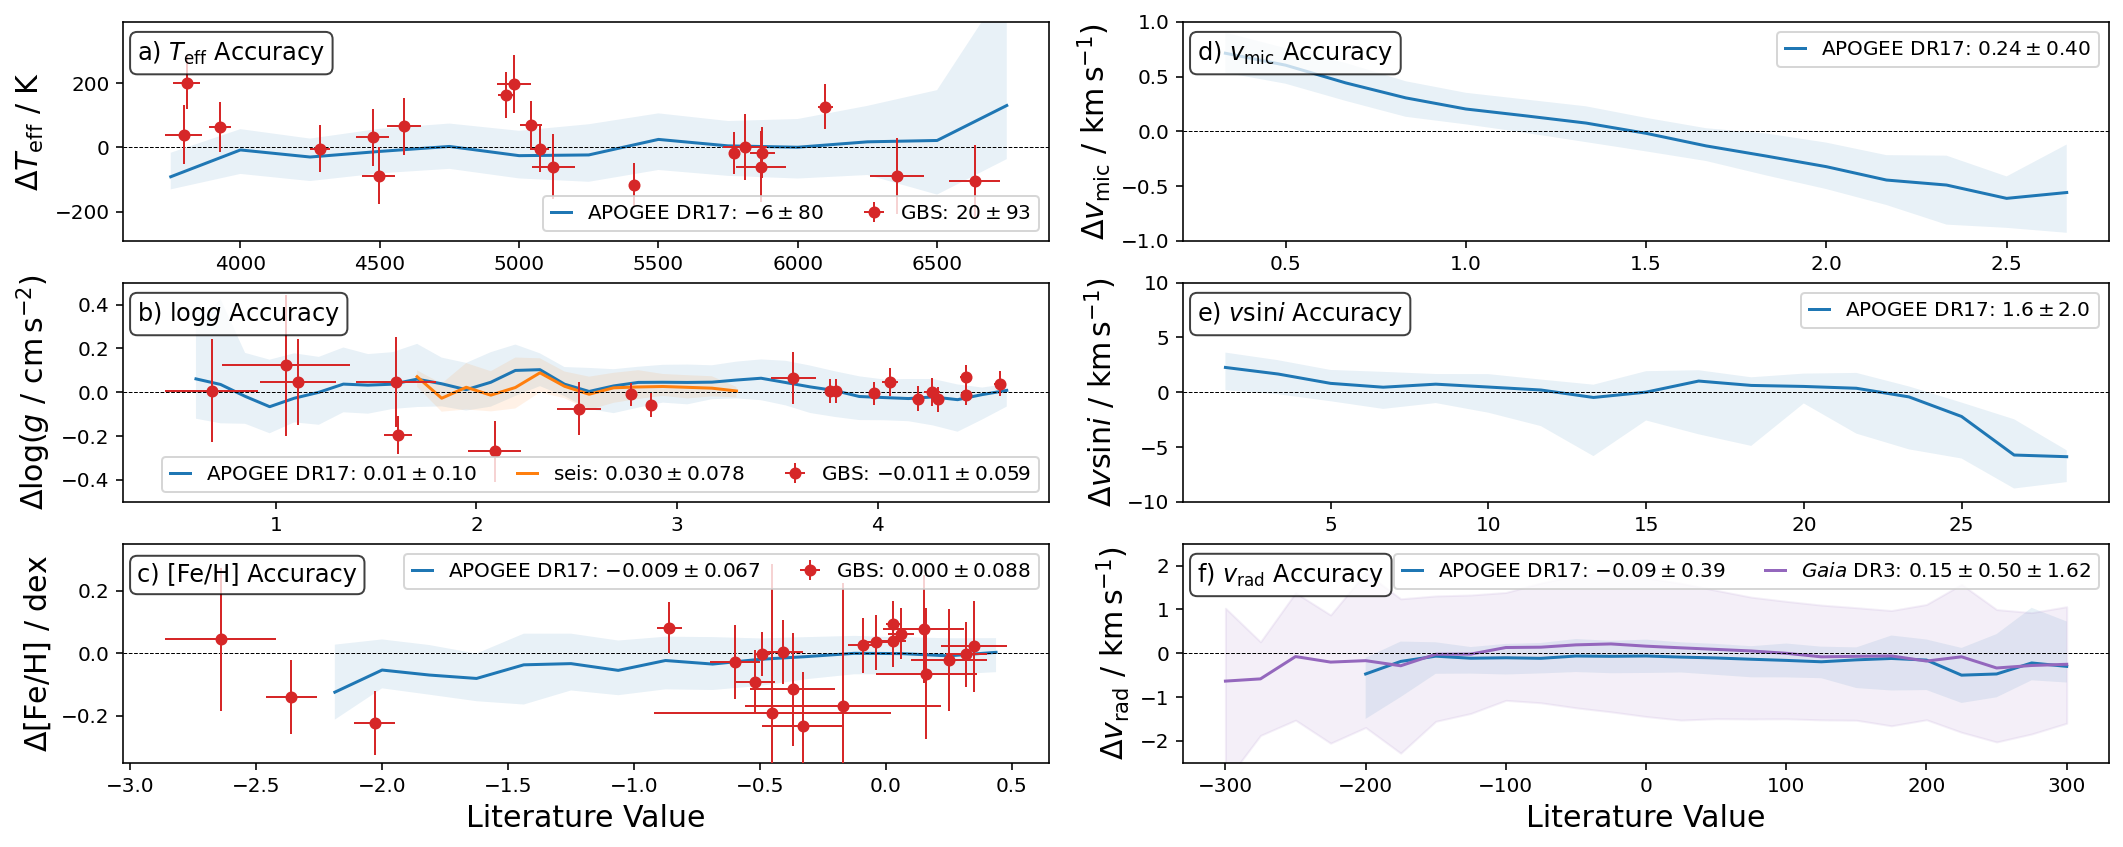

In [589]:
f, gs = plt.subplots(3,2,figsize=(15,6))

apo_use = (
    (galah_dr4_apogee_dr17['flag_sp'] == 0) &
    (galah_dr4_apogee_dr17['ASPCAPFLAG'] < 25231360)
)

"""
TEFF ACCURACY
"""

ax = gs[0,0]
ax.text(0.015,0.825,r'a) $T_\mathrm{eff}$ Accuracy',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

# GBS TEFF

flagged = ~(comparison['flag_sp'] < 32)# & (comparison['logg'] > 2.5)

ax.errorbar(
    comparison['teff_gbs'],
    comparison['teff'] - comparison['teff_gbs'],
    xerr = comparison['e_teff_gbs'],
    yerr = np.sqrt(comparison['e_teff_gbs']**2 + comparison['e_teff']**2),
    fmt = 'o', lw=1,ms=5,
    label=r'GBS: $'+str('%.0f' % lbol_bias['teff'][0])+' \pm '+str('%.0f' % lbol_bias['teff'][1])+'$',
    zorder=3,c='C3',
    )

# OTHER TEFF

teff_bins = np.linspace(3000,8000,21)
teff_step = 0.5*(teff_bins[1]-teff_bins[0])

teff_apogee = []

for teff_bin in teff_bins:
    in_teff_bin = (galah_dr4_apogee_dr17['TEFF'][apo_use] > teff_bin-teff_step) & (galah_dr4_apogee_dr17['TEFF'][apo_use] <= teff_bin+teff_step)
    if len(galah_dr4_apogee_dr17['teff'][apo_use][in_teff_bin]) > 10:
        teff_apogee.append(np.percentile(galah_dr4_apogee_dr17['teff'][apo_use][in_teff_bin] - galah_dr4_apogee_dr17['TEFF'][apo_use][in_teff_bin],q=[16,50,84]))
    else:
        teff_apogee.append([np.nan,np.nan,np.nan])
        
teff_apogee = np.array(teff_apogee)
        
teff_apogee_overall = np.array(np.round(np.nanpercentile(galah_dr4_apogee_dr17['teff'][apo_use] - galah_dr4_apogee_dr17['TEFF'][apo_use],q=[16,50,84]),0),dtype=int)

ax.plot(
    teff_bins,
    teff_apogee[:,1],
    label = r'APOGEE DR17: $'+str(teff_apogee_overall[1])+' \pm '+str(teff_apogee_overall[1]-teff_apogee_overall[0])+'}^{+'+str(teff_apogee_overall[2]-teff_apogee_overall[1])+'}$'
)
ax.fill_between(
    teff_bins,
    teff_apogee[:,0],
    teff_apogee[:,2],
    alpha = 0.1
)

ax.set_ylabel(r'$\Delta T_\mathrm{eff}~/~\mathrm{K}$',fontsize=15)
ax.legend(handlelength = 1,fontsize=10,ncol=3,loc='lower right')
ax.axhline(0,lw=0.5,ls='dashed',color='k')
ax.set_ylim(-290,390)


"""
LOGG ACCURACY
"""
ax = gs[1,0]
ax.text(0.015,0.825,r'b) $\log g$ Accuracy',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

# GBS LOGG

ax.errorbar(
    comparison['logg_gbs'],
    comparison['logg'] - comparison['logg_gbs'],
    xerr = comparison['e_logg_gbs'],
    yerr = np.sqrt(comparison['e_logg_gbs']**2 + comparison['e_logg']**2),
    fmt = 'o', lw=1,ms=5, zorder=3,c='C3',
    label=r'GBS: $'+str('%.3f' % lbol_bias['logg'][0])+' \pm '+str('%.3f' % lbol_bias['logg'][1])+'$',
    )

# OTHER LOGG

logg_bins = np.linspace(-0.5,5.5,50)
logg_step = 0.5*(logg_bins[1]-logg_bins[0])

logg_apogee = []

for logg_bin in logg_bins:
    in_logg_bin = (galah_dr4_apogee_dr17['LOGG'][apo_use] > logg_bin-logg_step) & (galah_dr4_apogee_dr17['LOGG'][apo_use] <= logg_bin+logg_step)
    if len(galah_dr4_apogee_dr17['logg'][apo_use][in_logg_bin]) > 10:
        logg_apogee.append(np.percentile(galah_dr4_apogee_dr17['logg'][apo_use][in_logg_bin] - galah_dr4_apogee_dr17['LOGG'][apo_use][in_logg_bin],q=[16,50,84]))
    else:
        logg_apogee.append([np.nan,np.nan,np.nan])
        
logg_apogee = np.array(logg_apogee)
        
logg_apogee_overall = np.nanpercentile(galah_dr4_apogee_dr17['logg'][apo_use] - galah_dr4_apogee_dr17['LOGG'][apo_use],q=[16,50,84])
    
ax.plot(
    logg_bins,
    logg_apogee[:,1],
    label = r'APOGEE DR17: $'+"{:.2f}".format(logg_apogee_overall[1])+' \pm '+"{:.2f}".format(0.5*(logg_apogee_overall[2]-logg_apogee_overall[0]))+'$'
)
ax.fill_between(
    logg_bins,
    logg_apogee[:,0],
    logg_apogee[:,2],
    alpha = 0.1
)

logg_seismic = []

for logg_bin in logg_bins:
    in_logg_bin = (galah_dr4_seismic['logg_seis'] > logg_bin-logg_step) & (galah_dr4_seismic['logg_seis'] <= logg_bin+logg_step)
    if len(galah_dr4_seismic['logg'][in_logg_bin]) > 10:
        logg_seismic.append(np.percentile(galah_dr4_seismic['logg'][in_logg_bin] - galah_dr4_seismic['logg_seis'][in_logg_bin],q=[16,50,84]))
    else:
        logg_seismic.append([np.nan,np.nan,np.nan])
        
logg_seismic = np.array(logg_seismic)
        
logg_seismic_overall = np.nanpercentile(galah_dr4_seismic['logg'] - galah_dr4_seismic['logg_seis'],q=[16,50,84])
    
ax.plot(
    logg_bins,
    logg_seismic[:,1],
    label = r'seis: $'+"{:.3f}".format(logg_seismic_overall[1])+' \pm '+"{:.3f}".format(0.5*(logg_seismic_overall[2]-logg_seismic_overall[0]))+'$'
)
ax.fill_between(
    logg_bins,
    logg_seismic[:,0],
    logg_seismic[:,2],
    alpha = 0.1
)

ax.set_ylabel(r'$\Delta \log (g~/~\mathrm{cm\,s^{-2}})$',fontsize=15)
ax.legend(handlelength = 1,fontsize=10,ncol=3,loc='lower right')
ax.axhline(0,lw=0.5,ls='dashed',color='k')
ax.set_ylim(-0.5,0.5)


"""
FE_H ACCURACY
"""
ax = gs[2,0]
ax.text(0.015,0.825,r'c) [Fe/H] Accuracy',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

# GBS [Fe/H]

ax.errorbar(
    comparison['fe_h_gbs'],
    comparison['fe_h'] - comparison['fe_h_gbs'],
    xerr = comparison['e_fe_h_gbs'],
    yerr = np.sqrt(comparison['e_fe_h_gbs']**2 + comparison['e_fe_h']**2),
    fmt = 'o', lw=1,ms=5, zorder=3,c='C3',
    label=r'GBS: $'+str('%.3f' % lbol_bias['fe_h'][0])+' \pm '+str('%.3f' % lbol_bias['fe_h'][1])+'$',
    )

# OTHER FEH

fe_h_bins = np.linspace(-3.5,1.0,25)
fe_h_step = 0.5*(fe_h_bins[1]-fe_h_bins[0])

fe_h_apogee = []

for fe_h_bin in fe_h_bins:
    in_fe_h_bin = (galah_dr4_apogee_dr17['FE_H'][apo_use] > fe_h_bin-fe_h_step) & (galah_dr4_apogee_dr17['FE_H'][apo_use] <= fe_h_bin+fe_h_step)
    if len(galah_dr4_apogee_dr17['fe_h'][apo_use][in_fe_h_bin]) > 10:
        fe_h_apogee.append(np.percentile(galah_dr4_apogee_dr17['fe_h'][apo_use][in_fe_h_bin] - galah_dr4_apogee_dr17['FE_H'][apo_use][in_fe_h_bin],q=[16,50,84]))
    else:
        fe_h_apogee.append([np.nan,np.nan,np.nan])
        
fe_h_apogee = np.array(fe_h_apogee)

fe_h_apogee_overall = np.nanpercentile(galah_dr4_apogee_dr17['fe_h'][apo_use] - galah_dr4_apogee_dr17['FE_H'][apo_use],q=[16,50,84])

ax.plot(
    fe_h_bins,
    fe_h_apogee[:,1],
    label = r'APOGEE DR17: $'+"{:.3f}".format(fe_h_apogee_overall[1])+' \pm '+"{:.3f}".format(0.5*(fe_h_apogee_overall[2]-fe_h_apogee_overall[0]))+'$'
)
ax.fill_between(
    fe_h_bins,
    fe_h_apogee[:,0],
    fe_h_apogee[:,2],
    alpha = 0.1
)

ax.set_xlabel(r'Literature Value',fontsize=15)
ax.set_ylabel(r'$\Delta \mathrm{[Fe/H]}~/~\mathrm{dex}$',fontsize=15)
ax.legend(handlelength = 1,fontsize=10,ncol=3,loc='upper right')
ax.axhline(0,lw=0.5,ls='dashed',color='k')
ax.set_ylim(-0.35,0.35)


"""
VMIC ACCURACY
"""
ax = gs[0,1]
ax.text(0.015,0.825,r'd) $v_\mathrm{mic}$ Accuracy',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

vmic_bins = np.linspace(0,4,25)
vmic_step = 0.5*(vmic_bins[1]-vmic_bins[0])

vmic_apogee = []

for vmic_bin in vmic_bins:
    in_vmic_bin = (galah_dr4_apogee_dr17['VMICRO'][apo_use] > vmic_bin-vmic_step) & (galah_dr4_apogee_dr17['VMICRO'][apo_use] <= vmic_bin+vmic_step)
    if len(galah_dr4_apogee_dr17['vmic'][apo_use][in_vmic_bin]) > 10:
        vmic_apogee.append(np.percentile(galah_dr4_apogee_dr17['vmic'][apo_use][in_vmic_bin] - galah_dr4_apogee_dr17['VMICRO'][apo_use][in_vmic_bin],q=[16,50,84]))
    else:
        vmic_apogee.append([np.nan,np.nan,np.nan])
        
vmic_apogee = np.array(vmic_apogee)
        
vmic_apogee_overall = np.nanpercentile(galah_dr4_apogee_dr17['vmic'][apo_use] - galah_dr4_apogee_dr17['VMICRO'][apo_use],q=[16,50,84])
    
ax.plot(
    vmic_bins,
    vmic_apogee[:,1],
    label = r'APOGEE DR17: $'+"{:.2f}".format(vmic_apogee_overall[1])+' \pm '+"{:.2f}".format(0.5*(vmic_apogee_overall[2]-vmic_apogee_overall[0]))+'$'
)
ax.fill_between(
    vmic_bins,
    vmic_apogee[:,0],
    vmic_apogee[:,2],
    alpha = 0.1
)

ax.set_ylabel(r'$\Delta v_\mathrm{mic}~/~\mathrm{km\,s^{-1}})$',fontsize=15)
ax.set_ylim(-1,1)
ax.axhline(0,lw=0.5,ls='dashed',color='k')
ax.legend(handlelength = 1,fontsize=10,ncol=3,loc='upper right')

"""
vsini ACCURACY
"""
ax = gs[1,1]
ax.text(0.015,0.825,r'e) $v \sin i$ Accuracy',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

vsini_bins = np.linspace(0,40,25)
vsini_step = 0.5*(vsini_bins[1]-vsini_bins[0])

vsini_apogee = []

for vsini_bin in vsini_bins:
    in_vsini_bin = (galah_dr4_apogee_dr17['VSINI'][apo_use] > vsini_bin-vsini_step) & (galah_dr4_apogee_dr17['VSINI'][apo_use] <= vsini_bin+vsini_step)
    if len(galah_dr4_apogee_dr17['vsini'][apo_use][in_vsini_bin]) > 10:
        vsini_apogee.append(np.percentile(galah_dr4_apogee_dr17['vsini'][apo_use][in_vsini_bin] - galah_dr4_apogee_dr17['VSINI'][apo_use][in_vsini_bin],q=[16,50,84]))
    else:
        vsini_apogee.append([np.nan,np.nan,np.nan])
        
vsini_apogee = np.array(vsini_apogee)
        
vsini_apogee_overall = np.nanpercentile(galah_dr4_apogee_dr17['vsini'][apo_use] - galah_dr4_apogee_dr17['VSINI'][apo_use],q=[16,50,84])

ax.plot(
    vsini_bins,
    vsini_apogee[:,1],
    label = r'APOGEE DR17: $'+"{:.1f}".format(vsini_apogee_overall[1])+' \pm '+"{:.1f}".format(vsini_apogee_overall[1]-vsini_apogee_overall[0])+'}^{+'+"{:.2f}".format(vsini_apogee_overall[2]-vsini_apogee_overall[1])+'}$'
)
ax.fill_between(
    vsini_bins,
    vsini_apogee[:,0],
    vsini_apogee[:,2],
    alpha = 0.1
)

ax.set_ylabel(r'$\Delta v \sin i~/~\mathrm{km\,s^{-1}})$',fontsize=15)
ax.legend(handlelength = 1,fontsize=10,ncol=3,loc='upper right')
ax.axhline(0,lw=0.5,ls='dashed',color='k')
ax.set_ylim(-10,10)

"""
vrad ACCURACY
"""
ax = gs[2,1]
ax.text(0.015,0.825,r'f) $v_\mathrm{rad}$ Accuracy',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

vrad_bins = np.linspace(-300,300,25)
vrad_step = 0.5*(vrad_bins[1]-vrad_bins[0])

vrad_apogee = []

for vrad_bin in vrad_bins:
    in_vrad_bin = (galah_dr4_apogee_dr17['VHELIO_AVG'][apo_use] > vrad_bin-vrad_step) & (galah_dr4_apogee_dr17['VHELIO_AVG'][apo_use] <= vrad_bin+vrad_step)
    if len(galah_dr4_apogee_dr17['VHELIO_AVG'][apo_use][in_vrad_bin]) > 10:
        vrad_apogee.append(np.percentile(galah_dr4_apogee_dr17['rv_comp_1'][apo_use][in_vrad_bin] - galah_dr4_apogee_dr17['VHELIO_AVG'][apo_use][in_vrad_bin],q=[16,50,84]))
    else:
        vrad_apogee.append([np.nan,np.nan,np.nan])

vrad_apogee = np.array(vrad_apogee)
        
vrad_apogee_overall = np.nanpercentile(galah_dr4_apogee_dr17['rv_comp_1'][apo_use] - galah_dr4_apogee_dr17['VHELIO_AVG'][apo_use],q=[16,50,84])

ax.plot(
    vrad_bins,
    vrad_apogee[:,1],
    label = r'APOGEE DR17: $'+"{:.2f}".format(vrad_apogee_overall[1])+' \pm '+"{:.2f}".format(vrad_apogee_overall[1]-vrad_apogee_overall[0])+'}^{+'+"{:.2f}".format(vrad_apogee_overall[2]-vrad_apogee_overall[1])+'}$'
)
ax.fill_between(
    vrad_bins,
    vrad_apogee[:,0],
    vrad_apogee[:,2],
    alpha = 0.1
)

vrad_gaia = []

use = (galah_dr4_raw['flag_sp'] == 0)

for vrad_bin in vrad_bins:
    in_vrad_bin = (galah_dr4_raw['rv_gaia_dr3'][use] > vrad_bin-vrad_step) & (galah_dr4_raw['rv_gaia_dr3'][use] <= vrad_bin+vrad_step)
    if len(galah_dr4_raw['rv_gaia_dr3'][use][in_vrad_bin]) > 10:
        vrad_gaia.append(np.nanpercentile(galah_dr4_raw['rv_comp_1'][use][in_vrad_bin] - galah_dr4_raw['rv_gaia_dr3'][use][in_vrad_bin],q=[16,50,84]))
    else:
        vrad_gaia.append([np.nan,np.nan,np.nan])
        
vrad_gaia = np.array(vrad_gaia)
        
vrad_gaia_overall = np.nanpercentile(galah_dr4_raw['rv_comp_1'][use] - galah_dr4_raw['rv_gaia_dr3'][use],q=[16,50,84])

ax.plot(
    vrad_bins,
    vrad_gaia[:,1],
    c = 'C4',
    #label = r'$Gaia$ DR3: $'+"{:.2f}".format(vrad_gaia_overall[1])+' \pm '+"{:.2f}".format(vrad_gaia_overall[1]-vrad_gaia_overall[0])+'}^{+'+"{:.2f}".format(vrad_gaia_overall[2]-vrad_gaia_overall[1])+'}$'
    # We have actually calculated the Gaia DR3 RV difference with a more robust approach (against binaries)
    label = r'$Gaia$ DR3: '+gaia_rv_gauss2_fit
)
ax.fill_between(
    vrad_bins,
    vrad_gaia[:,0],
    vrad_gaia[:,2],
    alpha = 0.1,
    color = 'C4'
)

ax.set_ylabel(r'$\Delta v_\mathrm{rad}~/~\mathrm{km\,s^{-1}})$',fontsize=15)
ax.set_xlabel(r'Literature Value',fontsize=15)
ax.legend(handlelength = 1,fontsize=10,ncol=3)
ax.axhline(0,lw=0.5,ls='dashed',color='k')
ax.set_ylim(-2.5,2.5)

plt.tight_layout(h_pad=0)
plt.savefig('figures/galah_dr4_validation_parameter_accuracy_'+setup+'.png',dpi=200,bbox_inches='tight')

AttributeError: module 'numpy' has no attribute 'lins'

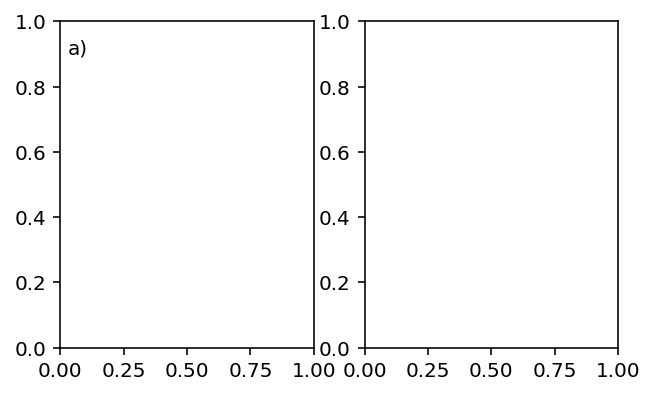

# Solar twins

In [ ]:
solar_twins = galah_dr4_raw

In [ ]:
rows = 4
columns = 8

f, gs = plt.subplots(rows,columns,figsize=(10,5),sharex=True,sharey=True)

vesta = galah_dr4_raw[galah_dr4_raw['tmass_id'] == 'VESTA']

elements = [
        'Li','C','N','O',
        'Na','Mg','Al','Si',
        'K','Ca','Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn',
        'Rb','Sr','Y','Zr','Mo','Ru',
        'Ba','La','Ce','Nd','Sm','Eu'
]

ff = "{:.3f}"

for index, element in enumerate(elements):
    
    row = int(np.floor(index/8))
    ax = gs[row,index-row*8]
    ax.text(0.05,0.8,element,transform=ax.transAxes,fontsize=15)
    xlimits = [-0.3,0.3]
    ax.set_xlim(xlimits)
    
    if element == 'Fe':
        label = 'fe_h'
    else:
        label = element.lower()+'_fe'

    ax.errorbar(
        [vesta[label][0]],
        [0],
        xerr = vesta['e_'+label][0],
        capsize=3, c='C0', fmt='o', ms=3
    )
    if np.isfinite(vesta[label][0]):
        ax.text(0,-0.5,r'$'+ff.format(vesta[label][0])+'\pm'+ff.format(vesta['e_'+label][0])+'$',ha='center',fontsize=8,c='C0')
    
    # Solar locus at [Fe/H] ~ 0
    use = (
        (np.abs(galah_dr4_raw['fe_h'] - 0.1) < 0.1) & 
        (galah_dr4_raw['flag_'+label] == 0) & 
        (galah_dr4_raw['r_med'] < 500)
    )
    
    # GBS
    if element in ['Mg','Si','Ca','Ti','Sc','V','Cr','Mn','Co','Ni']:
        
        gbs = comparison[element+'_fe'] - comparison[element+'_fe_gbs']
        perc = np.nanpercentile(gbs,q=[16,50,84])
        ax.errorbar(
            [perc[1]],
            [1],
            xerr = [[perc[2]-perc[1]],[perc[1]-perc[0]]],
            capsize=3, c='C1', fmt='o', ms=3
        )
        ax.text(0,0.5,r'$'+ff.format(perc[1])+'\pm'+ff.format(0.5*(perc[2]-perc[0]))+'$',ha='center',fontsize=8,c='C1')

    # Solar Circle

    if element in ['C','N','O','Na','Mg','Al','Si','K','Ca','Ti','V','Cr','Mn','Co','Ni','Cu','Ce']:
        
        use = (galah_dr4_raw['flag_'+element.lower()+'_fe']==0) & (galah_dr4_raw['r_med'] < 500) &  (np.abs(galah_dr4_raw['fe_h']) < 0.1)
        if len(galah_dr4_raw[element.lower()+'_fe'][use]) > 10:
            perc = np.nanpercentile(galah_dr4_raw[element.lower()+'_fe'][use],q=[16,50,84])
            ax.errorbar(
                [perc[1]],
                [2],
                xerr = [[perc[2]-perc[1]],[perc[1]-perc[0]]],
                capsize=3, c='C3', fmt='o', ms=3
            )
            ax.text(0,1.5,r'$'+ff.format(perc[1])+'\pm'+ff.format(0.5*(perc[2]-perc[0]))+'$',fontsize=8,c='C3',ha='center')

    # APOGEE DR17

    if element in ['C','N','O','Na','Mg','Al','Si','K','Ca','Ti','V','Cr','Mn','Co','Ni','Cu','Ce']:
        
        use = (galah_dr4_apogee_dr17['flag_'+element.lower()+'_fe']==0) & (galah_dr4_apogee_dr17[element.upper()+'_FE_FLAG']==0)
        if len(galah_dr4_apogee_dr17[element.lower()+'_fe'][use]) > 10:
            apo = galah_dr4_apogee_dr17[element.lower()+'_fe'][use] - galah_dr4_apogee_dr17[element.upper()+'_FE'][use]
            perc = np.nanpercentile(apo,q=[16,50,84])
            ax.errorbar(
                [perc[1]],
                [3],
                xerr = [[perc[2]-perc[1]],[perc[1]-perc[0]]],
                capsize=3, c='C4', fmt='o', ms=3
            )
            ax.text(0,2.5,r'$'+ff.format(perc[1])+'\pm'+ff.format(0.5*(perc[2]-perc[0]))+'$',fontsize=8,c='C4',ha='center')

    ax.axvline(0,lw=0.5,ls='dashed',c='k')
    ax.set_yticks([0,1,2,3])
#     ax.set_yticklabels([r'$\odot$','G',r'$R_\odot$','A'])
    ax.set_yticklabels([r'VESTA','GBS',r'$D < 500\,\mathrm{pc}$','APO. DR17'],fontsize=15)
    ax.set_ylim(-0.75,4)
    ax.set_xticks([-0.2,0.0,0.2])
    if row+1 == rows:
        ax.set_xlabel(r'$\Delta~\mathrm{[X/Fe]}$',fontsize=15)

plt.tight_layout(w_pad=0,h_pad=0)
plt.savefig('figures/galah_dr4_zeropoint_checks.png',dpi=200,bbox_inches='tight')

# 2) Precision

# Repeat observations

In [ ]:
galah_dr4_allspec = Table.read('../catalogs/galah_dr4_allspec_230206.fits')

# use only flag_sp 0 or flag_sp == 2048 to get down to the low SNR results
exclude_bad = (galah_dr4_allspec['flag_sp'] == 0) | (galah_dr4_allspec['flag_sp'] == 2048)
galah_dr4_allspec = galah_dr4_allspec[exclude_bad]

# 'emission': [1, 'Emission in Halpha/Hbeta detected'],
#  'ccd_missing': [2, 'Not all 4 CCDs available'],
#  'is_sb1': [4, 'Spectroscopic Binary SB1 (RV changes beyond 2sigma)'],
#  'is_sb2': [8, 'Spectroscopic Binary SB2 (Double line splitting)'],
#  'chi2_3sigma': [16, 'Chi2 unusually low/high by 3 sigma'],
#  'vsini_warn': [32, 'Broadening (vsini) warning'],
#  'vmic_warn': [64, 'Microturbulence (vmic) warning'],
#  'sb_triple_warn': [128, 'Double line splitting detected (SB2)'],
#  'teff_warn': [256, 'Temperature (teff) warning'],
#  'logg_warn': [512, 'Gravity (logg) warning'],
#  'fe_h_warn': [1024, '[Fe/H] (fe_h) warning'],
#  'snr_warn': [2048, 'Signal-to-noise indicates spectra not reliable'],
#  'not_converged': [4096, 'Not converged within 4 iterations'],
#  'no_model': [8192, 'Extrapolating spectrum model'],
#  'no_results': [16384, 'No spectroscopic analysis results available']

galah_dr4_allspec_left_right = join(galah_dr4_allspec,galah_dr4_allspec,keys='tmass_id')

# Exclude same entries
repeat = galah_dr4_allspec_left_right[(galah_dr4_allspec_left_right['sobject_id_1'] != galah_dr4_allspec_left_right['sobject_id_2'])]
repeat['rv_1'] = repeat['rv_comp_1_1']
repeat['rv_2'] = repeat['rv_comp_1_2']
repeat['e_rv_1'] = repeat['e_rv_comp_1_1']
repeat['e_rv_2'] = repeat['e_rv_comp_1_2']
repeat['snr_1'] = repeat['snr_px_ccd2_1']
repeat['snr_2'] = repeat['snr_px_ccd2_2']

In [414]:
galah_dr4_raw['rv'] = galah_dr4_raw['rv_comp_1']
galah_dr4_raw['e_rv'] = galah_dr4_raw['e_rv_comp_1']

In [415]:
ranges = dict()
ranges['teff'] = 200
ranges['logg'] = 0.5
ranges['logg_spec'] = 0.5
ranges['fe_h'] = 0.2
ranges['vmic'] = 0.2
ranges['vsini'] = 2
ranges['rv'] = 2

precision_labels = ['teff','logg','fe_h','vmic','vsini','rv']
for element in [
        'Li','C','N','O',
        'Na','Mg','Al','Si',
        'K','Ca','Sc','Ti','V','Cr','Mn','Co','Ni','Cu','Zn',
        'Rb','Sr','Y','Zr','Mo','Ru',
        'Ba','La','Ce','Nd','Sm','Eu'
]:
    precision_labels.append(element.lower()+'_fe')
    ranges[element.lower()+'_fe'] = 0.2

In [416]:
repeat_data = Table()

for label in precision_labels:
    repeat_data[label+'_mean'] = np.mean([repeat[label+'_1'],repeat[label+'_2']],axis=0)
    repeat_data[label+'_sigma'] = np.abs(repeat[label+'_1']-repeat[label+'_2'])/np.sqrt(2)
    #repeat_data[label+'_sigma'] = np.std([repeat[label+'_1'],repeat[label+'_2']],axis=0)
    repeat_data[label+'_cov'] = np.mean([repeat['e_'+label+'_1'],repeat['e_'+label+'_2']],axis=0)
    if label == 'logg':
        repeat_data[label+'_spec_sigma'] = np.abs(repeat[label+'_spec_1']-repeat[label+'_spec_2'])/np.sqrt(2)
        #repeat_data[label+'_spec_sigma'] = np.std([repeat[label+'_spec_1'],repeat[label+'_spec_2']],axis=0)
        repeat_data[label+'_spec_cov'] = np.mean([repeat['e_'+label+'_spec_1'],repeat['e_'+label+'_spec_2']],axis=0)

repeat_data['snr_mean'] = np.mean([repeat['snr_1'],repeat['snr_2']],axis=0)
repeat_data['snr_sigma'] = np.std([repeat['snr_1'],repeat['snr_2']],axis=0)

/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


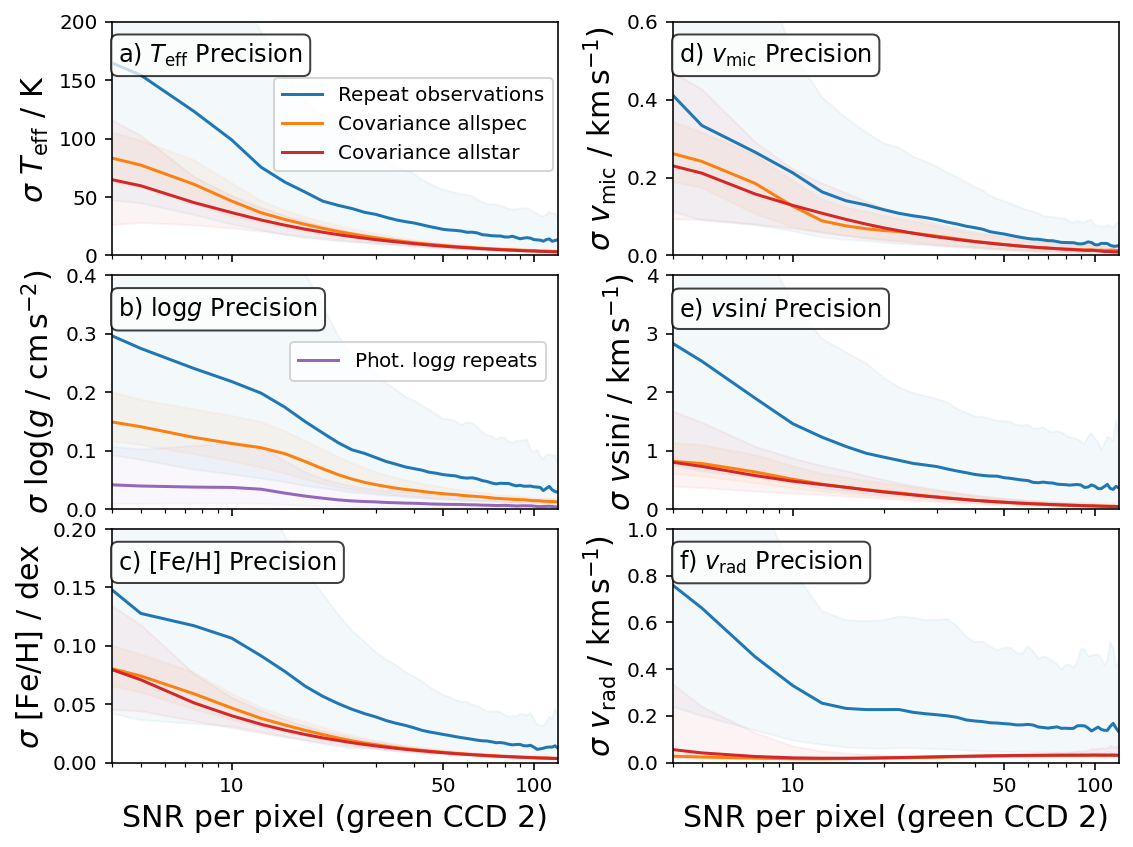

In [417]:
table_cov = dict()

labels = ['teff','logg','fe_h','vmic','vsini','rv']
labels_nice = ['$T_\mathrm{eff}$','$\log g$','$\mathrm{[Fe/H]}$','$v_\mathrm{mic}$','$v \sin i$','$v_\mathrm{rad}$']
panels = ['a)','b)','c)','d)','e)','f)']

snr_bin_size  = 5
snr_bins  = np.arange(snr_bin_size/2,200+snr_bin_size/2,snr_bin_size/2)

f, gs = plt.subplots(3,2,figsize=(8,6),sharex=True)

for label_index, label in enumerate(labels):
    
    if label_index < 3:
        ax = gs[label_index,0]
    else:
        ax = gs[label_index-3,1]
        
    ax.text(0.015,0.825,r''+panels[label_index]+' '+labels_nice[label_index]+' Precision',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))

    percentiles = [16,50,84]
    
    for setup in ['allspec','allstar','repeats']:
        for percentile in percentiles:
            table_cov[setup+'_'+label+'_'+str(percentile)] = []
            if (label == 'logg') & (setup == 'repeats'):
                table_cov[setup+'_'+label+'_phot_'+str(percentile)] = []

    for snr in snr_bins:

        # ALLSPEC
        in_bin = (
            (repeat_data['snr_mean'] > snr - 0.5*snr_bin_size) &
            (repeat_data['snr_mean'] <= snr + 0.5*snr_bin_size)
        )
        nr_in_bin = len(repeat_data[label+'_mean'][in_bin])
        if nr_in_bin > 10:
            perc = np.nanpercentile(repeat_data[label+'_cov'][in_bin],q=percentiles)
            if label == 'logg':
                perc = np.nanpercentile(repeat_data[label+'_spec_cov'][in_bin],q=percentiles)
        else:
            perc = [np.nan,np.nan,np.nan]
            if label == 'logg':
                perc_phot = [np.nan,np.nan,np.nan]

        table_cov['allspec_'+label+'_'+str(percentiles[0])].append(perc[1]-perc[0])
        table_cov['allspec_'+label+'_'+str(percentiles[1])].append(perc[1])
        table_cov['allspec_'+label+'_'+str(percentiles[2])].append(perc[2]-perc[1])
        
        # ALLSTAR
        in_bin = (
            (galah_dr4_raw['snr_px_ccd2'] > snr - 0.5*snr_bin_size) &
            (galah_dr4_raw['snr_px_ccd2'] <= snr + 0.5*snr_bin_size)
        )
        nr_in_bin = len(galah_dr4_raw[label][in_bin])
        if nr_in_bin > 10:
            perc = np.nanpercentile(galah_dr4_raw['e_'+label][in_bin],q=percentiles)
        else:
            perc = [np.nan,np.nan,np.nan]
        table_cov['allstar_'+label+'_'+str(percentiles[0])].append(perc[1]-perc[0])
        table_cov['allstar_'+label+'_'+str(percentiles[1])].append(perc[1])
        table_cov['allstar_'+label+'_'+str(percentiles[2])].append(perc[2]-perc[1])

        # REPEATS
        in_bin = (
            (repeat_data['snr_mean'] > snr - 0.5*snr_bin_size) &
            (repeat_data['snr_mean'] <= snr + 0.5*snr_bin_size)
        )
        nr_in_bin = len(repeat_data[label+'_mean'][in_bin])
        if nr_in_bin > 10:
            perc = np.nanpercentile(repeat_data[label+'_sigma'][in_bin],q=percentiles)
            if label == 'logg':
                perc = np.nanpercentile(repeat_data[label+'_spec_sigma'][in_bin],q=percentiles)
                perc_phot = np.nanpercentile(repeat_data[label+'_sigma'][in_bin],q=percentiles)
        else:
            perc = [np.nan,np.nan,np.nan]
            if label == 'logg':
                perc_phot = [np.nan,np.nan,np.nan]
        table_cov['repeats_'+label+'_'+str(percentiles[0])].append(perc[1]-perc[0])
        table_cov['repeats_'+label+'_'+str(percentiles[1])].append(perc[1])
        table_cov['repeats_'+label+'_'+str(percentiles[2])].append(perc[2]-perc[1])
        if label == 'logg':
            table_cov['repeats_'+label+'_phot_'+str(percentiles[0])].append(perc_phot[1]-perc_phot[0])
            table_cov['repeats_'+label+'_phot_'+str(percentiles[1])].append(perc_phot[1])
            table_cov['repeats_'+label+'_phot_'+str(percentiles[2])].append(perc_phot[2]-perc_phot[1])
        
    for setup in ['allspec','allstar','repeats']:
        for percentile in percentiles:
            table_cov[setup+'_'+label+'_'+str(percentile)] = np.array(table_cov[setup+'_'+label+'_'+str(percentile)])
            if (label == 'logg') & (setup == 'repeats'):
                table_cov[setup+'_'+label+'_phot_'+str(percentile)] = np.array(table_cov[setup+'_'+label+'_phot_'+str(percentile)])

    for setup, color in zip(['repeats','allspec','allstar'],['C0','C1','C3']):
        
        if label_index == 0:
            if setup == 'allstar':
                legend_label = 'Covariance allstar'
            if setup == 'allspec':
                legend_label = 'Covariance allspec'
            if setup == 'repeats':
                legend_label = 'Repeat observations'
        else:
            legend_label = '_nolegend_'
        
        ax.plot(
            snr_bins,
            table_cov[setup+'_'+label+'_50'],
            label = legend_label,
            color = color
        )
        ax.fill_between(
            snr_bins,
            table_cov[setup+'_'+label+'_50']-table_cov[setup+'_'+label+'_16'],
            table_cov[setup+'_'+label+'_50']+table_cov[setup+'_'+label+'_84'],
            label = '_nolegend_',
            alpha = 0.05,
            color = color
        )
    if label == 'logg':
        ax.plot(
            snr_bins,
            table_cov['repeats_'+label+'_phot_50'],
            label = r'Phot. $\log g$ repeats',
            color = 'C4'
        )
        ax.fill_between(
            snr_bins,
            table_cov['repeats_'+label+'_phot_50']-table_cov['repeats_'+label+'_phot_16'],
            table_cov['repeats_'+label+'_phot_50']+table_cov['repeats_'+label+'_phot_84'],
            label = '_nolegend_',
            alpha = 0.05,
            color = 'C4'
        )

    if label == 'teff':
        ax.set_ylim(0,200)
        ax.set_ylabel(r'$\sigma~T_\mathrm{eff}~/~\mathrm{K}$',fontsize=15)
    elif label == 'logg':
        ax.set_ylim(0,0.4)
        ax.set_ylabel(r'$\sigma~\log (g~/~\mathrm{cm\,s^{-2}})$',fontsize=15)
    elif label == 'fe_h':
        ax.set_ylim(0,0.2)
        ax.set_ylabel(r'$\sigma~\mathrm{[Fe/H]}~/~\mathrm{dex}$',fontsize=15)
    elif label == 'vmic':
        ax.set_ylim(0,0.6)
        ax.set_ylabel(r'$\sigma~v_\mathrm{mic}~/~\mathrm{km\,s^{-1}})$',fontsize=15)
    elif label == 'vsini':
        ax.set_ylim(0,4)
        ax.set_ylabel(r'$\sigma~v \sin i~/~\mathrm{km\,s^{-1}})$',fontsize=15)
    elif label == 'rv':
        ax.set_ylim(0,1.)
        ax.set_ylabel(r'$\sigma~v_\mathrm{rad}~/~\mathrm{km\,s^{-1}})$',fontsize=15)

    ax.set_xscale('log')
    ax.set_xlim(4,120)
    ax.set_xticks([10,50,100])
    ax.set_xticklabels([10,50,100])

    if label_index == 0:
        ax.legend(loc=(0.365,0.36))
    elif label_index == 1:
        ax.legend(loc=(0.4,0.55))
    if label_index in [2,5]:
        ax.set_xlabel(r'SNR per pixel (green CCD 2)',fontsize=15)

plt.tight_layout(h_pad=0,w_pad=0)
plt.savefig('figures/galah_dr4_precision_parameters.png',dpi=200,bbox_inches='tight')

/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/pkg/linux/anaconda-20210218/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice e

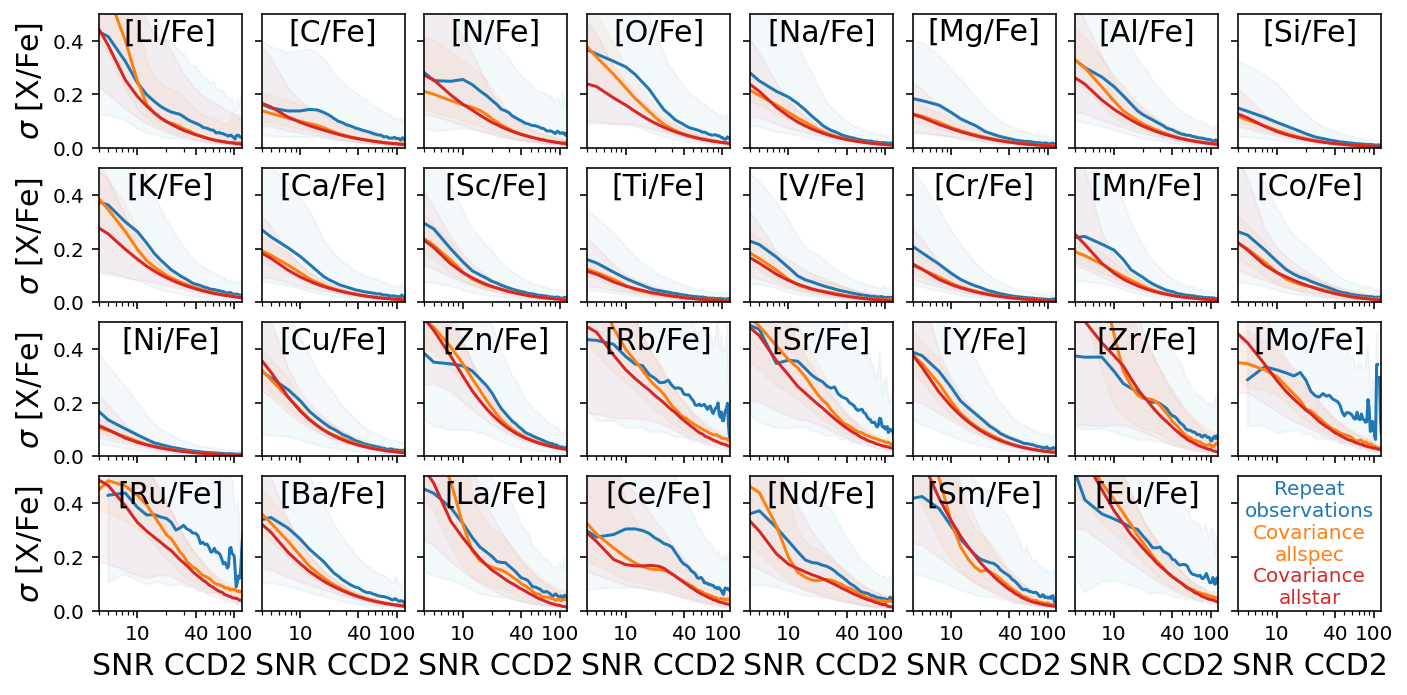

In [425]:
table_cov = dict()

elements = [
        'Li','C','N','O',
        'Na','Mg','Al','Si',
        'K','Ca','Sc','Ti','V','Cr','Mn',#'Fe',
        'Co','Ni','Cu','Zn',
        'Rb','Sr','Y','Zr','Mo','Ru',
        'Ba','La','Ce','Nd','Sm','Eu','labels'
]

snr_bin_size  = 5
snr_bins  = np.arange(snr_bin_size/2,200+snr_bin_size/2,snr_bin_size/2)

rows = 4
columns = 8

f, gs = plt.subplots(rows,columns,figsize=(10,5),sharex=True,sharey=True)

for index, element in enumerate(elements):
    
    label = element.lower()+'_fe'

    row = int(np.floor(index/8))
    ax = gs[row,index-row*8]
    
    # Last panel has legend
    if element == 'labels':
        
        ax.text(0.5,0.825,'Repeat\nobservations',color='C0',ha='center',va='center',transform=ax.transAxes,fontsize=10)
        ax.text(0.5,0.5,'Covariance\nallspec',color='C1',ha='center',va='center',transform=ax.transAxes,fontsize=10)
        ax.text(0.5,0.175,'Covariance\nallstar',color='C3',ha='center',va='center',transform=ax.transAxes,fontsize=10)

    else:    
        ax.text(0.5,0.8,'['+element+'/Fe]',transform=ax.transAxes,fontsize=15,ha='center')

        percentiles = [16,50,84]

        for setup in ['allspec','allstar','repeats']:
            for percentile in percentiles:
                table_cov[setup+'_'+label+'_'+str(percentile)] = []

        for snr in snr_bins:

            # ALLSPEC
            in_bin = (
                (repeat_data['snr_mean'] > snr - 0.5*snr_bin_size) &
                (repeat_data['snr_mean'] <= snr + 0.5*snr_bin_size)
            )
            nr_in_bin = len(repeat_data[label+'_mean'][in_bin])
            if nr_in_bin > 10:
                perc = np.nanpercentile(repeat_data[label+'_cov'][in_bin],q=percentiles)
            else:
                perc = [np.nan,np.nan,np.nan]
                if label == 'logg':
                    perc_phot = [np.nan,np.nan,np.nan]

            table_cov['allspec_'+label+'_'+str(percentiles[0])].append(perc[1]-perc[0])
            table_cov['allspec_'+label+'_'+str(percentiles[1])].append(perc[1])
            table_cov['allspec_'+label+'_'+str(percentiles[2])].append(perc[2]-perc[1])

            # ALLSTAR
            in_bin = (
                (galah_dr4_raw['snr_px_ccd2'] > snr - 0.5*snr_bin_size) &
                (galah_dr4_raw['snr_px_ccd2'] <= snr + 0.5*snr_bin_size)
            )
            nr_in_bin = len(galah_dr4_raw[label][in_bin])
            if nr_in_bin > 10:
                perc = np.nanpercentile(galah_dr4_raw['e_'+label][in_bin],q=percentiles)
            else:
                perc = [np.nan,np.nan,np.nan]
            table_cov['allstar_'+label+'_'+str(percentiles[0])].append(perc[1]-perc[0])
            table_cov['allstar_'+label+'_'+str(percentiles[1])].append(perc[1])
            table_cov['allstar_'+label+'_'+str(percentiles[2])].append(perc[2]-perc[1])

            # REPEATS
            in_bin = (
                (repeat_data['snr_mean'] > snr - 0.5*snr_bin_size) &
                (repeat_data['snr_mean'] <= snr + 0.5*snr_bin_size)
            )
            nr_in_bin = len(repeat_data[label+'_mean'][in_bin])
            if nr_in_bin > 10:
                perc = np.nanpercentile(repeat_data[label+'_sigma'][in_bin],q=percentiles)
                if label == 'logg':
                    perc = np.nanpercentile(repeat_data[label+'_spec_sigma'][in_bin],q=percentiles)
                    perc_phot = np.nanpercentile(repeat_data[label+'_sigma'][in_bin],q=percentiles)
            else:
                perc = [np.nan,np.nan,np.nan]
                if label == 'logg':
                    perc_phot = [np.nan,np.nan,np.nan]
            table_cov['repeats_'+label+'_'+str(percentiles[0])].append(perc[1]-perc[0])
            table_cov['repeats_'+label+'_'+str(percentiles[1])].append(perc[1])
            table_cov['repeats_'+label+'_'+str(percentiles[2])].append(perc[2]-perc[1])
            if label == 'logg':
                table_cov['repeats_'+label+'_phot_'+str(percentiles[0])].append(perc_phot[1]-perc_phot[0])
                table_cov['repeats_'+label+'_phot_'+str(percentiles[1])].append(perc_phot[1])
                table_cov['repeats_'+label+'_phot_'+str(percentiles[2])].append(perc_phot[2]-perc_phot[1])

        for setup in ['allspec','allstar','repeats']:
            for percentile in percentiles:
                table_cov[setup+'_'+label+'_'+str(percentile)] = np.array(table_cov[setup+'_'+label+'_'+str(percentile)])
                if (label == 'logg') & (setup == 'repeats'):
                    table_cov[setup+'_'+label+'_phot_'+str(percentile)] = np.array(table_cov[setup+'_'+label+'_phot_'+str(percentile)])

        for setup, color in zip(['repeats','allspec','allstar'],['C0','C1','C3']):

            if label_index == 0:
                if setup == 'allstar':
                    legend_label = 'Covariance allstar'
                if setup == 'allspec':
                    legend_label = 'Covariance allspec'
                if setup == 'repeats':
                    legend_label = 'Repeat observations'
            else:
                legend_label = '_nolegend_'

            ax.plot(
                snr_bins,
                table_cov[setup+'_'+label+'_50'],
                label = legend_label,
                color = color
            )
            ax.fill_between(
                snr_bins,
                table_cov[setup+'_'+label+'_50']-table_cov[setup+'_'+label+'_16'],
                table_cov[setup+'_'+label+'_50']+table_cov[setup+'_'+label+'_84'],
                label = '_nolegend_',
                alpha = 0.05,
                color = color
            )

        ax.set_xscale('log')
        ax.set_xlim(4,120)
        ax.set_xticks([10,40,100])
        ax.set_xticklabels([10,40,100])

        ax.set_ylim(0,0.5)

        if index-row*8 == 0:
            ax.set_ylabel(r'$\sigma~\mathrm{[X/Fe]}$',fontsize=15)

    if row+1==rows:
        ax.set_xlabel(r'SNR CCD2',fontsize=15)

plt.tight_layout(h_pad=0,w_pad=0)
plt.savefig('figures/galah_dr4_precision_abundances.png',dpi=200,bbox_inches='tight')

In [419]:
raise ValueError('Should we rather check precision and accuracy of [X/H] than [X/Fe]?')

ValueError: Should we rather check precision and accuracy of [X/H] than [X/Fe]?

# Covariance Matrices

In [470]:
vesta_cov = np.load('../analysis_products/210115/210115002201239/210115002201239_single_fit_covariances.npz',allow_pickle=True)
arcturus_cov = np.load('../analysis_products/150210/150210005801171/150210005801171_single_fit_covariances.npz')
# if you need to see what keywords are in the file:
# vesta_cov.files
# ['model_labels', 'model_name', 'model_parameters', 'model_covariances']

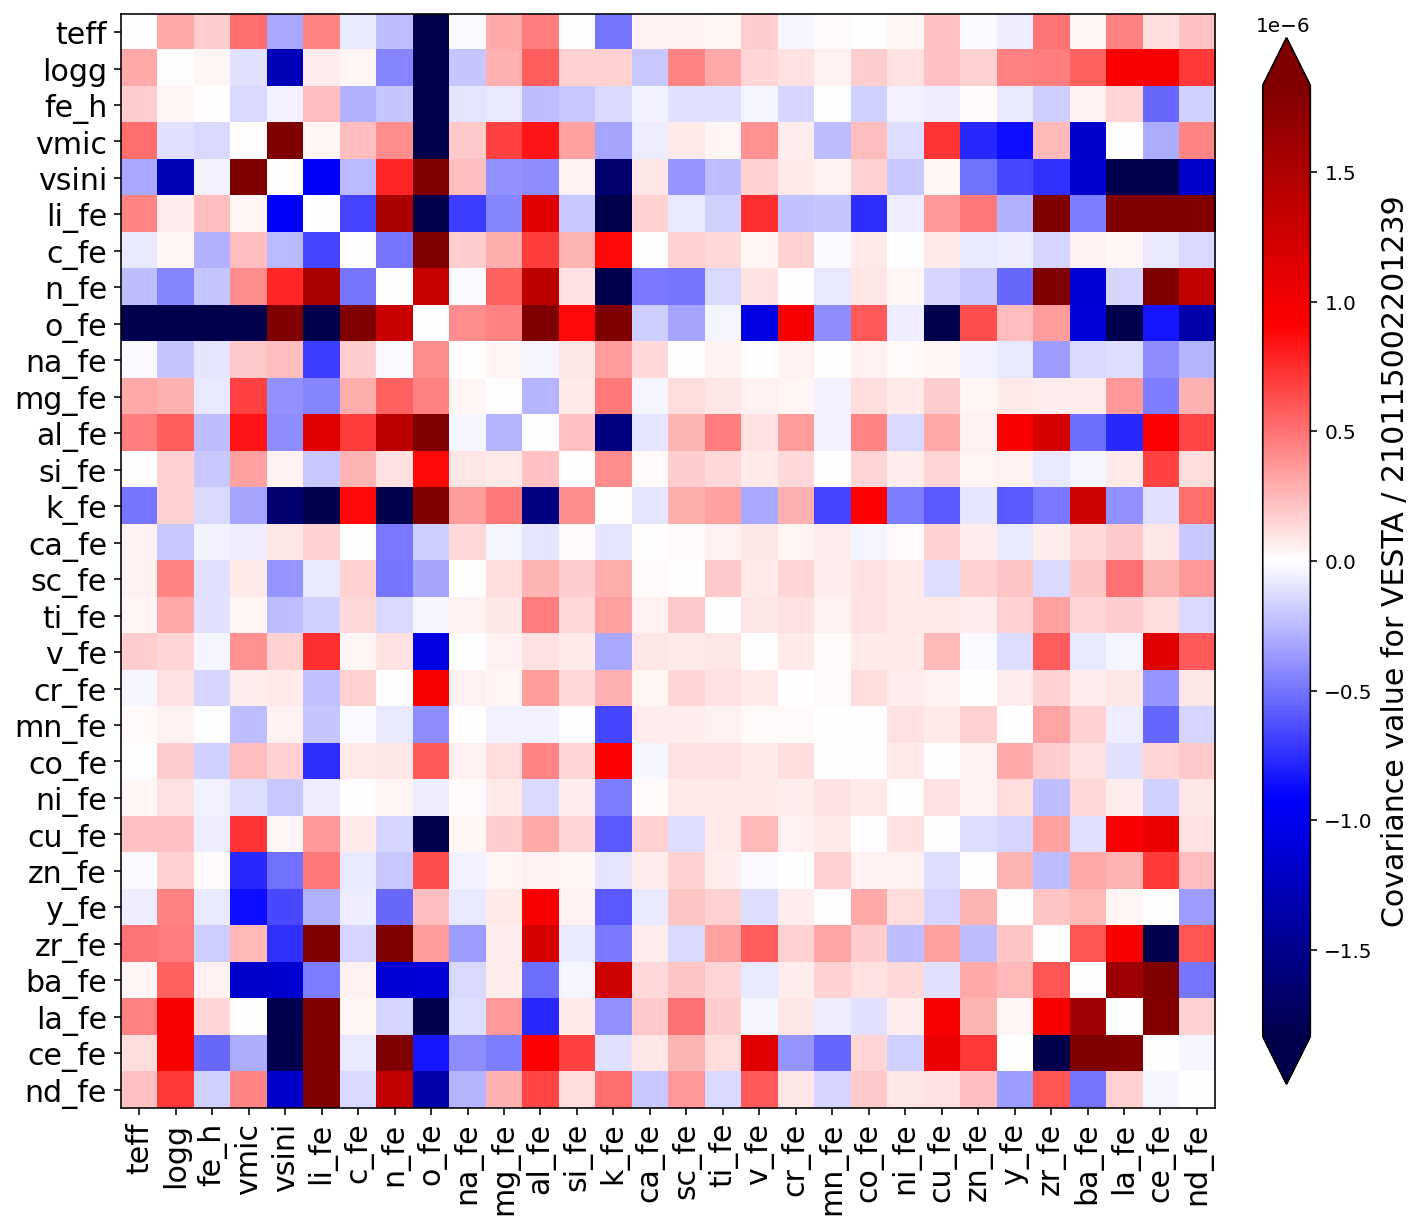

In [557]:
f, ax = plt.subplots(figsize=(10,10))

diag = vesta_cov['model_covariances']
# Null the diagonal entries
diag[np.arange(len(diag)),np.arange(len(diag))] = 0.
p95 = np.percentile(np.abs(diag),q=95)

s = ax.imshow(
    diag,
    cmap = 'seismic',
    vmin = -p95,
    vmax = p95,
)

ax.set_xticks(np.arange(len(vesta_cov['model_labels'])))
ax.set_xticklabels(vesta_cov['model_labels'],rotation=90,fontsize=15)
ax.set_yticks(np.arange(len(vesta_cov['model_labels'])))
ax.set_yticklabels(vesta_cov['model_labels'],fontsize=15)
cbar = plt.colorbar(s,ax=ax,extend='both',fraction=0.04, pad=0.04)
cbar.set_label('Covariance value for VESTA / 210115002201239',fontsize=15)
plt.tight_layout()
plt.savefig('figures/covariance_vesta.png',dpi=200,bbox_inches='tight')

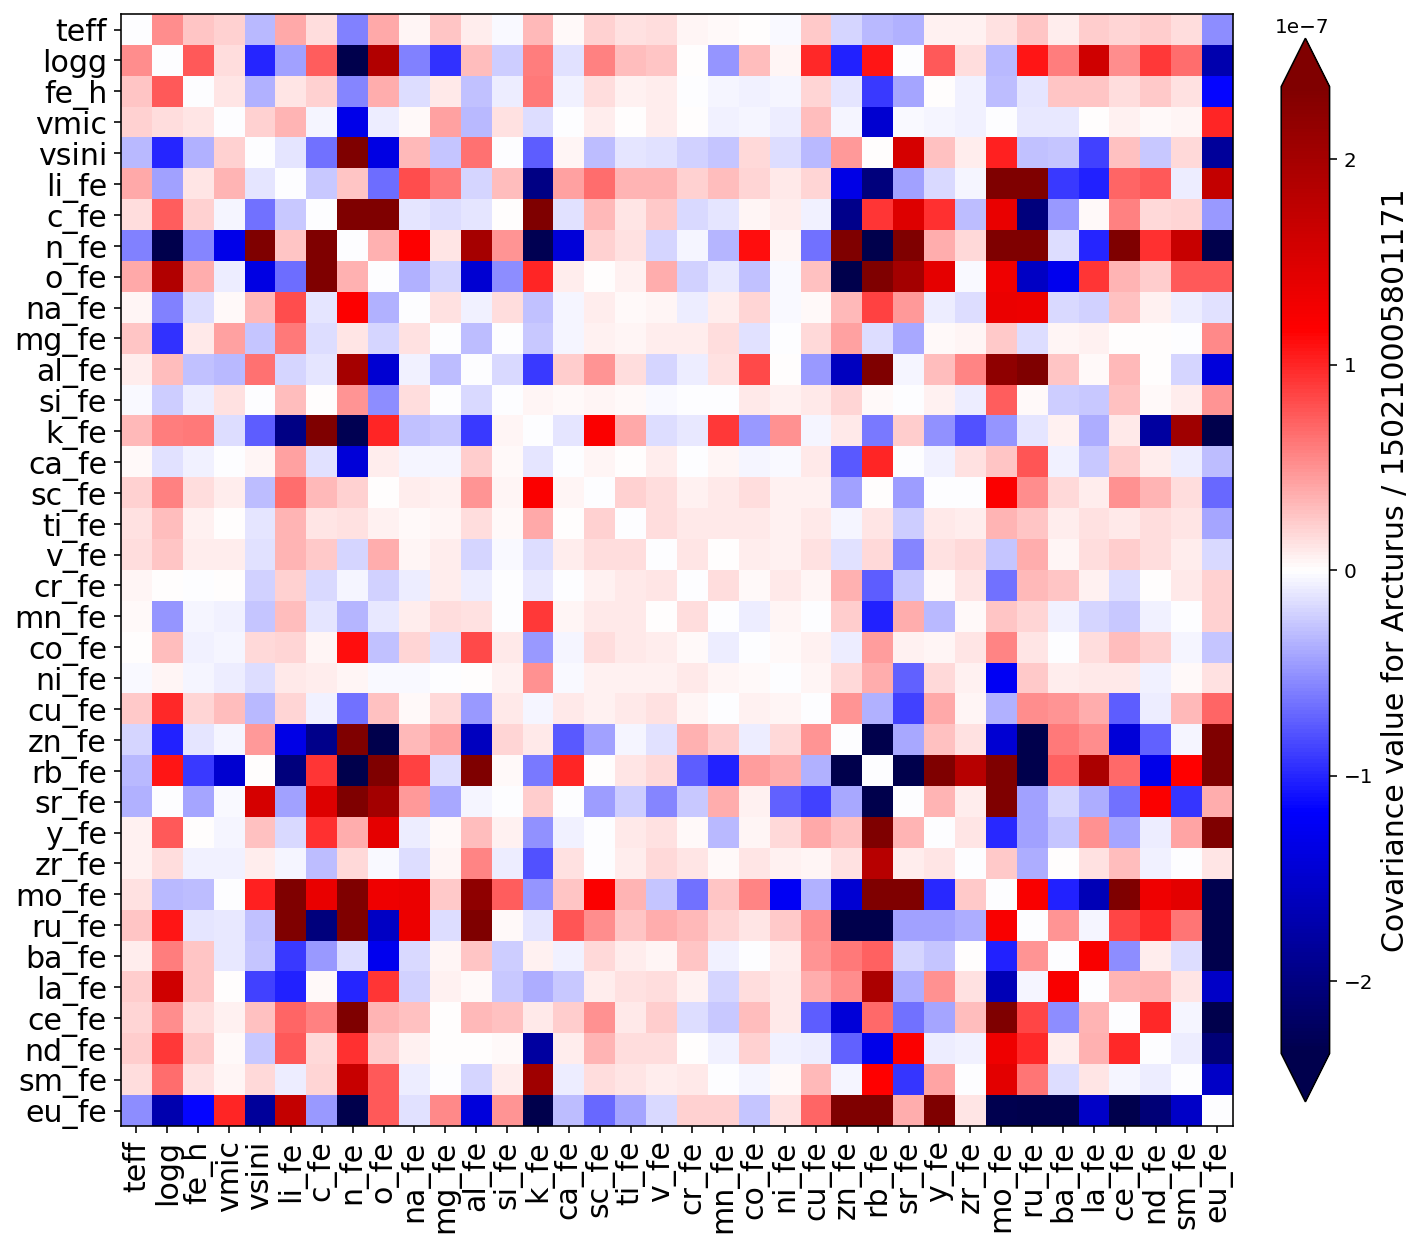

In [558]:
f, ax = plt.subplots(figsize=(10,10))

diag = arcturus_cov['model_covariances']
# Null the diagonal entries
diag[np.arange(len(diag)),np.arange(len(diag))] = 0.
p95 = np.percentile(np.abs(diag),q=95)

s = ax.imshow(
    diag,
    cmap = 'seismic',
    vmin = -p95,
    vmax = p95,
)

ax.set_xticks(np.arange(len(arcturus_cov['model_labels'])))
ax.set_xticklabels(arcturus_cov['model_labels'],rotation=90,fontsize=15)
ax.set_yticks(np.arange(len(arcturus_cov['model_labels'])))
ax.set_yticklabels(arcturus_cov['model_labels'],fontsize=15)
cbar = plt.colorbar(s,ax=ax,extend='both',fraction=0.04, pad=0.04)
cbar.set_label('Covariance value for Arcturus / 150210005801171',fontsize=15)
plt.tight_layout()
plt.savefig('figures/covariance_arcturus.png',dpi=200,bbox_inches='tight')